## Firstly, training Endotypist<sup>XMBD</sup>

Users can refer to [here](https://doi.org/10.6084/m9.figshare.24151701) giving the description about how to prepare input data required by Endotypist<sup>XMBD</sup> with Python. For users who play with R, [here](./nips2021_bmmc_donor1_shuffle_tutorial.ipynb)) is an example for the preparation of input data with R.

We re-used the dataset provided by the COvid-19 Multi-omics Blood ATlas (COMBAT) Consortium. The original dataset is retrievable [here](https://doi.org/10.5281/zenodo.6120249).

This examples illustrate a scenario where individuals expose to a variety of infections. It is used to validate whether Endotypist<sup>XMBD</sup> can identify different types of infectious responses.



In [1]:
%%bash

CUDA_VISIBLE_DEVICES=1  python scClassifier5.py --sup-data-file ~/zfeng/COVID_PBMC_COMBAT/infection_endotype_counts.csv \
                        --sup-condition-file ~/zfeng/COVID_PBMC_COMBAT/infection_endotype_phenotype.txt \
                        --sup-condition2-file ~/zfeng/COVID_PBMC_COMBAT/infection_endotype_uwv.txt \
                        -lr 0.0001 \
                        -n 300 \
                        -bs 1000 \
                        --cuda \
                        --seed 0 \
                        --layer-dropout-rate 0.1 \
                        -hl 500 \
                        -zd 100 \
                        -zi exact \
                        -likeli negbinomial \
                        --condition-type onehot \
                        --condition2-type onehot \
                        -rt \
                        --save-model infection_endotype_model.pth 2>&1 | tee COVID_combat.log



1 epoch: avg losses 22370688.8801 0.0000 elapsed 70.5537 seconds
2 epoch: avg losses 19669540.3110 0.0000 elapsed 63.0913 seconds
3 epoch: avg losses 17844329.4134 0.0000 elapsed 71.8774 seconds
4 epoch: avg losses 15837548.0848 0.0000 elapsed 71.4194 seconds
5 epoch: avg losses 13525946.0983 0.0000 elapsed 71.6948 seconds
6 epoch: avg losses 11075244.9126 0.0000 elapsed 72.0530 seconds
7 epoch: avg losses 8806755.0826 0.0000 elapsed 70.6701 seconds
8 epoch: avg losses 7206638.7617 0.0000 elapsed 71.3715 seconds
9 epoch: avg losses 6354900.5890 0.0000 elapsed 63.2500 seconds
10 epoch: avg losses 6003193.2469 0.0000 elapsed 67.8703 seconds
11 epoch: avg losses 5872486.4522 0.0000 elapsed 72.7918 seconds
12 epoch: avg losses 5806715.2816 0.0000 elapsed 72.3728 seconds
13 epoch: avg losses 5757909.9243 0.0000 elapsed 71.8248 seconds
14 epoch: avg losses 5717138.7904 0.0000 elapsed 72.2611 seconds
15 epoch: avg losses 5656063.7735 0.0000 elapsed 72.2773 seconds
16 epoch: avg losses 5604635

## Secondly, generating the cell expression after removing unwanted variations

In [1]:
import numpy as np
import pandas as pd

from scClassifier5 import scClassifier5
from utils.scdata_cached import SingleCellCached

import torch
from torch.utils.data import DataLoader


import datatable as dt

from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks

%load_ext rpy2.ipython


In [2]:

ModelPath = 'infection_endotype_model.pth'
DataPath='/home/zfeng/zfeng/COVID_PBMC_COMBAT/infection_endotype_counts.csv'
LabelPath=None
ConditionPath=None
ConditionPath2=None


In [3]:
# load model
model = torch.load(ModelPath)

batch_size = 10000

use_float64 = False
use_cuda = True

In [4]:
# load data
data_cached = SingleCellCached(DataPath, LabelPath, ConditionPath, ConditionPath2, 'condition', use_cuda=False, use_float64 = use_float64)
data_loader = DataLoader(data_cached, batch_size = batch_size, shuffle = False)

In [5]:
# predict conditions
exprs = []
phenos = []
# use the appropriate data loader
for xs,ys,ks,ks2 in data_loader:
    if use_cuda:
        xs = xs.cuda()

    expr = model.generate_scaled_expression(xs, mute_condition2=True, mute_noise=False)
    ks = model.classifier_condition_score(xs)

    if use_cuda:
        expr = expr.cpu().detach().numpy()
        ks = ks.cpu().detach().numpy()
    else:
        expr = expr.detach().numpy()
        ks = ks.detach().numpy()

    exprs.append(expr)
    phenos.append(ks)


exprs = np.concatenate(exprs, axis=0)
phenos = np.concatenate(phenos, axis=0)



In [6]:
cells = pd.read_csv('/home/zfeng/zfeng/COVID_PBMC_COMBAT/infection_endotype_cell.csv',header=0)
genes = pd.read_csv('/home/zfeng/zfeng/COVID_PBMC_COMBAT/infection_endotype_gene.csv',header=0)

In [7]:
df = pd.DataFrame(exprs, columns=genes.iloc[:,0].values, index=cells.iloc[:,0].values).reset_index()
dt.Frame(df).to_csv('/home/zfeng/zfeng/COVID_PBMC_COMBAT/infection_endotype_denoised_expression.txt')

In [8]:
df = pd.DataFrame(phenos, index=cells.iloc[:,0].values, columns=model.condition_names).reset_index()
dt.Frame(df).to_csv('/home/zfeng/zfeng/COVID_PBMC_COMBAT/infection_endotype_phenotype_score.txt')

## Thirdly, plotting results with R

In [9]:
%%R

library(Seurat)
library(dplyr)
library(data.table)
library(uwot)
library(patchwork)

meta <- fread('/home/zfeng/zfeng/COVID_PBMC_COMBAT/infection_endotype_meta.csv', data.table = FALSE, header = TRUE)
rownames(meta) <- meta[,1]
meta <- meta[,-1]

data <- fread('/home/zfeng/zfeng/COVID_PBMC_COMBAT/infection_endotype_denoised_expression.txt',data.table = FALSE, header = TRUE, nThread = 40)
rownames(data) <- data[,1]
data <- data[,-1]

embed <- umap(data, n_threads = 40, pca=20)
colnames(embed) <- c('UMAP_1','UMAP_2')


recon <- CreateSeuratObject(data[,1:10] %>% t, meta.data = meta[rownames(data),])
recon[['umap']] <- CreateDimReducObject(embed %>% as.matrix(), key = 'UMAP_')





    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Attaching SeuratObject

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

data.table 1.14.8 using 24 threads (see ?getDTthreads).  Latest news: r-datatable.com

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

Loading required package: Matrix
|--------------------------------------------------|
|==================================================|
|--------------------------------------------------|
|==================================================|


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`


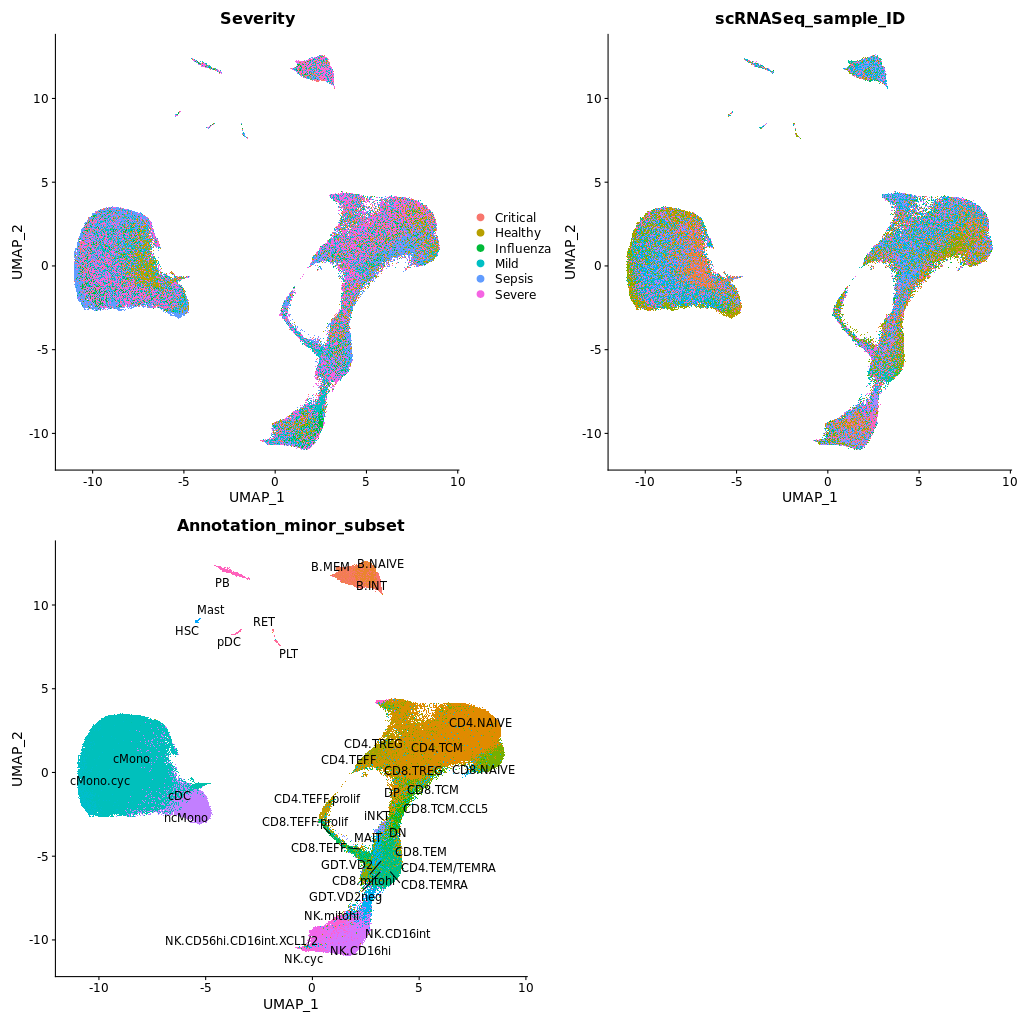

In [10]:
%%R -w 1024 -h 1024 -u px


(DimPlot(recon, reduction = 'umap', group.by = 'Severity') + (DimPlot(recon, reduction = 'umap', group.by = 'scRNASeq_sample_ID')+NoLegend())) /
(DimPlot(recon, reduction = 'umap', group.by = 'Annotation_minor_subset', label=TRUE, repel=TRUE) +NoLegend() + plot_spacer())

[Here](../impact_score.R) is the R script to compute the impact score indicating how a infectious disease condition influences cell states. 

number of iterations= 9 
number of iterations= 8 
number of iterations= 10 
number of iterations= 10 
number of iterations= 9 
number of iterations= 9 
number of iterations= 9 
number of iterations= 10 
number of iterations= 8 
number of iterations= 11 
number of iterations= 9 
number of iterations= 13 
number of iterations= 9 
number of iterations= 6 
number of iterations= 10 
number of iterations= 7 
number of iterations= 9 
number of iterations= 11 
number of iterations= 10 
number of iterations= 12 
number of iterations= 8 
number of iterations= 8 
number of iterations= 8 
number of iterations= 8 
number of iterations= 8 
number of iterations= 7 
number of iterations= 9 
number of iterations= 8 
number of iterations= 5 
number of iterations= 5 
number of iterations= 6 
number of iterations= 6 
number of iterations= 7 
number of iterations= 10 
number of iterations= 8 
number of iterations= 11 
number of iterations= 9 
number of iterations= 5 
number of iterations= 9 
number of iter

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 10 rows containing missing values (`position_stack()`). 




Attaching package: ‘cowplot’

The following object is masked from ‘package:patchwork’:

    align_plots



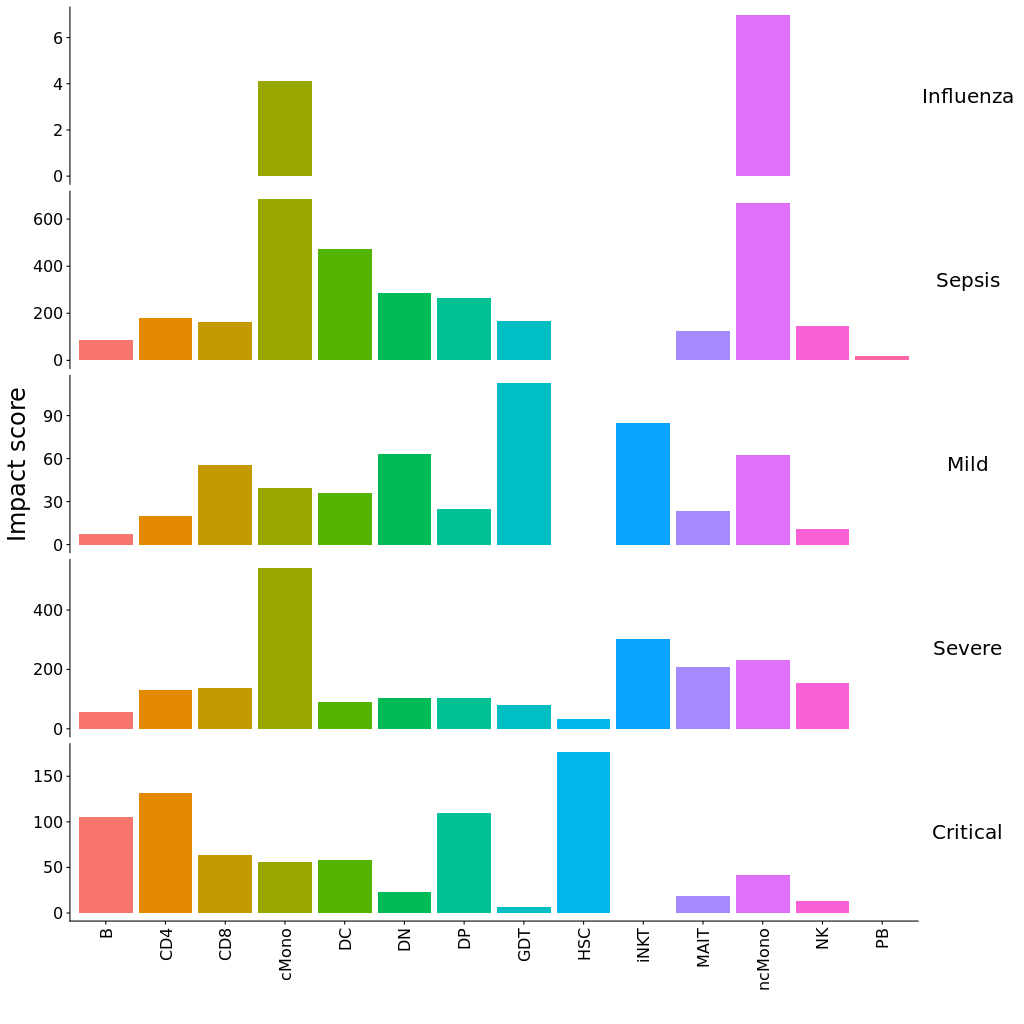

In [12]:
%%R -w 1024 -h 1024 -u px
library(ggplot2)
library(cowplot)

source('/home/zfeng/zfeng/COVID_PBMC_COMBAT/impact_score.R')


score <- read.csv('/home/zfeng/zfeng/COVID_PBMC_COMBAT/infection_endotype_phenotype_score.txt', header = TRUE, row.names = 1)


df_all <- list()

for (severity in unique(meta$Severity)) {
  for (celltype in unique(meta$Annotation_major_subset)) {
      cells <- meta %>% filter(Severity %in% severity) %>% filter(Annotation_major_subset %in% celltype) %>% rownames()
      others <- meta %>% filter(Severity %in% 'Healthy') %>% filter(Annotation_major_subset %in% celltype) %>% rownames()
      
      if ((severity %in% colnames(score)) & (length(cells)>30) & (length(others)>30)) {
        df <- score[cells,severity,drop=FALSE]
        colnames(df) <- 'score'
        
        df2 <- score[others,severity,drop=FALSE]
        colnames(df2) <- 'score'
        
        
        res <- impact_score(df$score, df2$score)
        
        df_all <- c(df_all, list(c(severity, celltype, res[1])))
      }
    }
}

df_all_ <- do.call('rbind', df_all) %>% as.data.frame()
df_all_[,3] <- as.numeric(df_all_[,3])



levels <- c('Influenza','Sepsis','Mild','Severe','Critical')
df_all_$V1 <- factor(df_all_$V1, levels = levels)
ggplot(df_all_, aes(V2,V3,fill=V2)) + 
    geom_bar(stat = 'identity') +
    labs(x='',y='Impact score') +
    facet_grid(V1~., scales = 'free') +
    theme_cowplot() +
    theme(strip.background = element_blank(),
          strip.text.y = element_text(size=20, angle = 0),
          axis.title = element_text(size=24),
          axis.text = element_text(size=16),
          axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
    NoLegend()